### Loading the data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import cv2
import os
import imghdr
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

2025-03-24 22:03:42.275870: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 22:03:42.282777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742834022.291190   14384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742834022.293580   14384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 22:03:42.302011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)
print('Tensorflow Keras version:', tf.keras.__version__)
!nvcc --version
print("TensorFlow CUDA Version:", tf.sysconfig.get_build_info()['cuda_version'])
print("TensorFlow cuDNN Version:", tf.sysconfig.get_build_info()['cudnn_version'])

TensorFlow version: 2.18.0
TensorFlow Hub version: 0.16.1
Tensorflow Keras version: 3.8.0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Tue_Oct_29_23:50:19_PDT_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0
TensorFlow CUDA Version: 12.5.1
TensorFlow cuDNN Version: 9


In [3]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
print("Detailed Device Information:")
for device in devices:
    print(f"Name: {device.name}, Type: {device.device_type}, Description: {device.physical_device_desc}")

Detailed Device Information:
Name: /device:CPU:0, Type: CPU, Description: 
Name: /device:GPU:0, Type: GPU, Description: device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


I0000 00:00:1742834023.528412   14384 gpu_device.cc:2022] Created device /device:GPU:0 with 9332 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [4]:
path = '/home/smayan/Desktop/Cricket-shot-classification/Data/data'

In [5]:
for img_class in os.listdir(path):
    print(img_class)

sweep
late_cut
straight
pull
defense
flick
hook
cover
square_cut
lofted


In [6]:
data = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=420,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
)

Found 13500 files belonging to 10 classes.


I0000 00:00:1742834023.766537   14384 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9332 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


In [7]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
data_iterator = data.as_numpy_iterator()
data_iterator

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x79efba702c50>)

In [9]:
batch = data_iterator.next()

In [10]:
batch[0].shape

(32, 224, 224, 3)

In [11]:
batch[1]

array([8, 6, 0, 0, 2, 0, 0, 2, 6, 9, 6, 6, 3, 6, 3, 9, 9, 0, 6, 6, 1, 3,
       0, 7, 9, 0, 2, 9, 8, 3, 6, 9], dtype=int32)

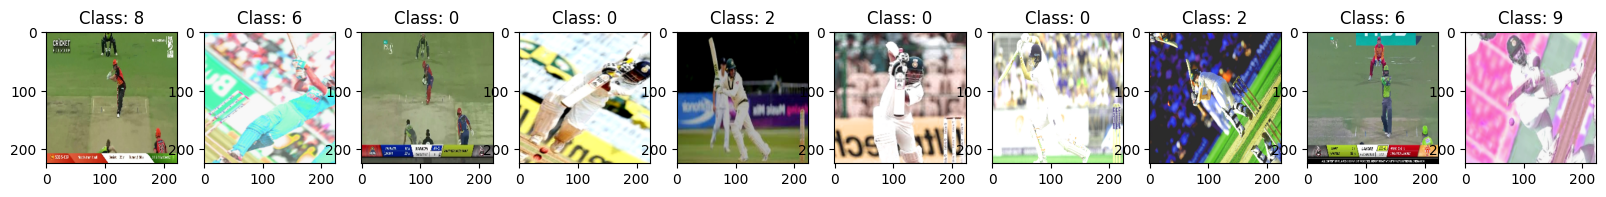

In [12]:
fig,ax = plt.subplots(ncols = 10, figsize = (20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(f'Class: {batch[1][idx]}')

### Preprocessing the Data

In [13]:
data = data.map(lambda x,y: (x/255, y)) # Tensorflow tf.data.Dataset.map() function is used to apply a function to all the elements of a dataset.

In [14]:
scaled_iterator = data.as_numpy_iterator()

In [15]:
scaled_batch = scaled_iterator.next()

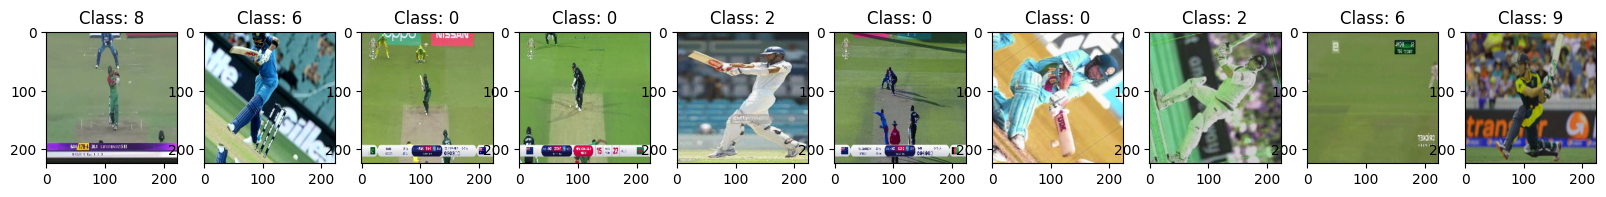

In [16]:
fig,ax = plt.subplots(ncols = 10, figsize = (20,20))
for idx, img in enumerate(scaled_batch[0][:10]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(f'Class: {batch[1][idx]}')

In [17]:
len(data)

422

In [18]:
train_size = int(len(data) * 0.7)
test_size = int(len(data) * 0.2)
val_size = int(len(data) * 0.1)+1

In [19]:
sum([train_size, test_size, val_size])

422

In [20]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

/home/smayan/Desktop/AI-ML-DS/AI-and-ML-Course/.conda/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,578,474 (21.28 MB)

 Trainable params: 5,578,474 (21.28 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
log_path = '/home/smayan/Desktop/Cricket-shot-classification/Logs'

In [27]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1)

In [28]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


I0000 00:00:1742834026.231789   14544 service.cc:148] XLA service 0x79ee14004cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742834026.231810   14544 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-03-24 22:03:46.248027: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742834026.353606   14544 cuda_dnn.cc:529] Loaded cuDNN version 90600


  7/295 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.1533 - loss: 2.8216

I0000 00:00:1742834028.511872   14544 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.2890 - loss: 1.9548 - val_accuracy: 0.5785 - val_loss: 1.2370
Epoch 2/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6476 - loss: 1.0409 - val_accuracy: 0.7413 - val_loss: 0.7801
Epoch 3/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8329 - loss: 0.4942 - val_accuracy: 0.7907 - val_loss: 0.6881
Epoch 4/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9318 - loss: 0.1999 - val_accuracy: 0.8198 - val_loss: 0.7636
Epoch 5/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9700 - loss: 0.1055 - val_accuracy: 0.8227 - val_loss: 0.7438
Epoch 6/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9777 - loss: 0.0803 - val_accuracy: 0.8299 - val_loss: 0.6512
Epoch 7/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9869 - loss: 0.0490 - val_accuracy: 0.8358 - val_loss: 0.8300
Epoch 8/10
295/295 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9820 - loss: 0.0661 - val_accuracy: 0.83